In [1]:
import numpy as np
import scipy
from numpy import pi, sqrt, cos, sin, exp, real, imag
import matplotlib.pyplot as plt


In [2]:
A = 0.72
H = 7.12 
L = 8e3

r = 0.3

a_r = 0.1
dL = 0

g = 9.81
sigma = 1.4e-4

epsilon = A / H
eta = sigma * L / sqrt(g * H)
U = epsilon * sigma * L
kappa = g * H / (sigma * L) ** 2

In [3]:
x_x = np.linspace(0, 1+dL, 1000)

factor = 1
h_fx = lambda x: factor * x
h_fx_dx = lambda x: factor
h_fx_dxx = lambda x: 0

In [4]:
# complex system of equations:

def deriv(x_x, y_x):
    h_x, h_x_dx, h_x_dxx = h_fx(x_x), h_fx_dx(x_x), h_fx_dxx(x_x)

    # helper functions that often appear
    s1_x = scipy.special.erf(2 * (1 - h_x) / a_r)
    s2_x = exp(-4 * (1-h_x)**2 / a_r**2)
    s1_x_dx = h_x_dx * (-4) / pi**0.5 / a_r * s2_x
    s2_x_dx = h_x_dx * 8 * (1-h_x) / a_r**2 * s2_x

    s1_x_dxx = -4 / pi**0.5 / a_r * (h_x_dxx * s2_x + h_x_dx * s2_x_dx)
    s2_x_dxx = 8 / a_r**2 * (h_x_dxx * (1-h_x) * s2_x - h_x_dx  * h_x_dx * s2_x + h_x_dx * (1-h_x) * s2_x_dx)

    # leading order
    eta0_x = 0.5 * (1 + s1_x)
    eta0_x_dx = 0.5 * s1_x_dx
    Y0_x  = eta0_x * (1 - h_x) + a_r / 4 / pi**0.5 * s2_x
    Y0_x_dx = 0.5 * (s1_x_dx * (1 - h_x) - (s1_x + 1) * h_x_dx) + a_r / 4 / pi**0.5 * s2_x_dx
    Y0_x_dxx = 0.5 * (s1_x_dxx * (1 - h_x) - s1_x_dx * h_x_dx - s1_x_dx * h_x_dx - (s1_x + 1) * h_x_dxx) + a_r / 4 / pi**0.5 * s2_x_dxx

    u_x, u_x_dx = y_x

    dz_x = 1j * (Y0_x_dx * u_x + Y0_x * u_x_dx) / eta0_x

    # dz_x_dx2 = 1j * (Y0_x_dxx * u_x + Y0_x_dx * u_x_dx + Y0_x_dx + u_x_dx + Y0_x * u_x_dxx) / eta0_x - 1j / eta0_x**2 * eta0_x_dx * (Y0_x_dx * u_x + Y0_x * u_x_dx) 
    dz_x_dx = 1 / kappa * (- r / Y0_x * u_x - 1j * u_x)
    

    u_x_dxx = -1j * (
        eta0_x_dx * dz_x / Y0_x +
        eta0_x * dz_x_dx / Y0_x +
        - eta0_x * dz_x * Y0_x_dx / Y0_x**2
    ) - (
        Y0_x_dxx * u_x / Y0_x + 
        Y0_x_dx * u_x_dx / Y0_x +
        - Y0_x_dx * u_x * Y0_x_dx / Y0_x**2
    )

    return [u_x_dx, u_x_dxx]




In [5]:
from scipy.integrate import solve_ivp
from scipy.optimize import root


def ivp(u_start, dense_output=False):
    x_range = [0, 1]


    u_start = u_start[0] + 1j * u_start[1]
    dz_start = 1 + 0j

    h_x, h_x_dx, h_x_dxx = h_fx(0), h_fx_dx(0), h_fx_dxx(0)
    s1_x = scipy.special.erf(2 * (1 - h_x) / a_r)
    s2_x = exp(-4 * (1-h_x)**2 / a_r**2)
    s1_x_dx = h_x_dx * (-4) / pi**0.5 / a_r * s2_x
    s2_x_dx = h_x_dx * 8 * (1-h_x) / a_r**2 * s2_x
    eta0_x = 0.5 * (1 + s1_x)
    eta0_x_dx = 0.5 * s1_x_dx
    Y0_x  = eta0_x * (1 - h_x) + a_r / 4 / pi**0.5 * s2_x
    Y0_x_dx = 0.5 * (s1_x_dx * (1 - h_x) - (s1_x + 1) * h_x_dx) + a_r / 4 / pi**0.5 * s2_x_dx


    # u_dx_start = (- eta0_x * 1j * dz_start - Y0_x_dx * u_start ) / Y0_x

    u_dx_start = (-1j * eta0_x * dz_start - u_start * Y0_x_dx)  / Y0_x


    y0 = np.array([u_start, u_dx_start])
    sol = solve_ivp(deriv, x_range, y0, dense_output=dense_output, rtol=1e-7)

    return sol


def mismatch(s):
    # velocity should be zero
    sol = ivp(s)
    
    return [real(sol.y[0, -1]), imag(sol.y[0, -1])]


s_guess = [0.1, 0.1]
res = root(mismatch, s_guess)

print(res)

 message: The solution converged.
 success: True
  status: 1
     fun: [-1.900e-16 -5.579e-15]
       x: [ 4.878e-03  9.944e-01]
  method: hybr
    nfev: 8
    fjac: [[-9.998e-01 -1.879e-02]
           [ 1.879e-02 -9.998e-01]]
       r: [-6.972e+01  3.450e-05 -6.972e+01]
     qtf: [-1.395e-11  4.073e-11]


  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  4.068e-02 ...  9.966e-01  1.000e+00]
        y: [[ 4.87772952e-03+9.94447321e-01j
              5.07979186e-03+9.94196502e-01j ...
              2.11312201e-03+1.12563899e-01j
             -1.89952221e-16-5.57887070e-15j]
            [ 4.87772952e-03-5.55267904e-03j
              5.05948992e-03-6.80558995e-03j ...
             -5.74331236e-01-3.06751766e+01j
             -6.77449806e-01-3.60413142e+01j]]
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x0000019F3A07E660>
 t_events: None
 y_events: None
     nfev: 284
     njev: 0
      nlu: 0


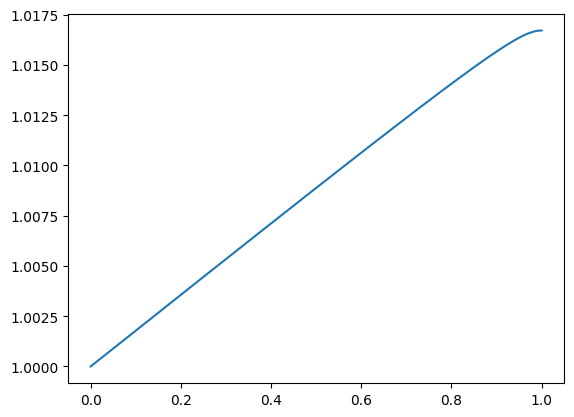

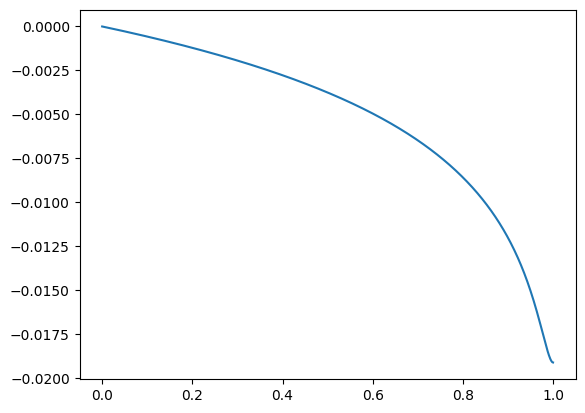

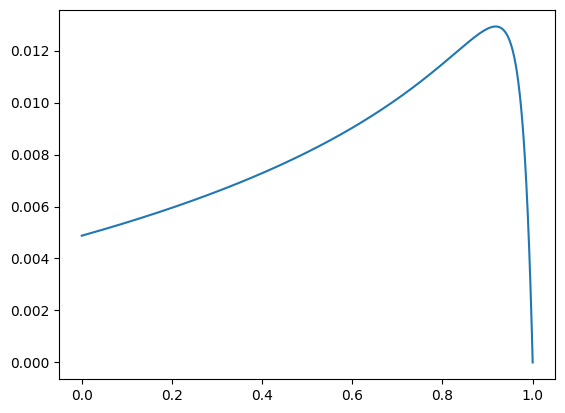

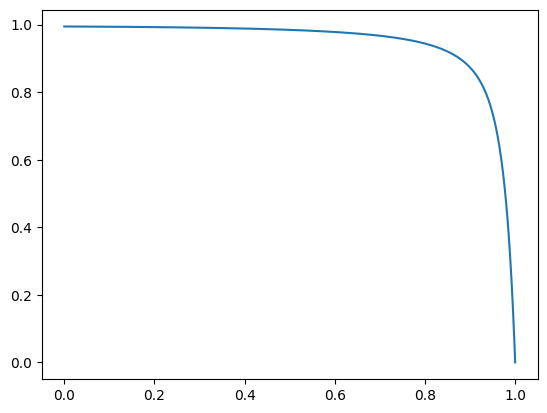

In [6]:

sol = ivp(res.x, True)
print(sol)


x_x = np.linspace(0, 1, 1000)
u_x, u_x_dx = sol.sol(x_x)

h_x, h_x_dx, h_x_dxx = h_fx(x_x), h_fx_dx(x_x), h_fx_dxx(x_x)
s1_x = scipy.special.erf(2 * (1 - h_x) / a_r)
s2_x = exp(-4 * (1-h_x)**2 / a_r**2)
s1_x_dx = h_x_dx * (-4) / pi**0.5 / a_r * s2_x
s2_x_dx = h_x_dx * 8 * (1-h_x) / a_r**2 * s2_x
eta0_x = 0.5 * (1 + s1_x)
eta0_x_dx = 0.5 * s1_x_dx
Y0_x  = eta0_x * (1 - h_x) + a_r / 4 / pi**0.5 * s2_x
Y0_x_dx = 0.5 * (s1_x_dx * (1 - h_x) - (s1_x + 1) * h_x_dx) + a_r / 4 / pi**0.5 * s2_x_dx

dz_x = 1j * (Y0_x_dx * u_x + Y0_x * u_x_dx) / eta0_x


uc_x, us_x = real(u_x), imag(u_x)
dzc_x, dzs_x = real(dz_x), imag(dz_x)



plt.plot(x_x, dzc_x)
plt.show()
plt.plot(x_x, dzs_x)
plt.show()

plt.plot(x_x, uc_x)
plt.show()
plt.plot(x_x, us_x)
plt.show()